Import appropriate libraries. 

In [2]:
import google 
from google.colab import auth
import datetime
from googleapiclient.discovery import build
import io
import os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np 


Mount driver (GPU). 

In [3]:
auth.authenticate_user()
drive_service = build('drive', 'v3')
drive.mount('/content/gdrive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

Mounted at /content/gdrive
cuda:0


Setup tensorboard. 

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

from torch.utils.tensorboard import SummaryWriter

Download relevant data. 

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Setup model (all CNN) 

In [6]:
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

(b) 

Fix hyperparameters to $\beta = 0.9$, $\rho = 0.6$, and weight-decay as 0.001. We can find the optimal $\eta_{max}$. $\eta$ is varied over every iteration according to the update rule: $\eta (t+1) = 1.15\eta (t)$, starting at $\eta(0) = 10^{-5}$ 

In [7]:
loss_total = [] 
alphas = [] 
t = 0
T_max = 100 
T_0 = T_max/5 
eta_0 = 10**(-5) 
alpha = eta_0 
net = allcnn_t()
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir='train')
optimizer = optim.SGD(net.parameters(), lr=eta_0, momentum=0.9, weight_decay=0.001)
for i, data in enumerate(trainloader, 0): 
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    alpha = 1.15*(alpha)
    alphas.append(alpha)
    optimizer = optim.SGD(net.parameters(), lr=alpha, momentum=0.9, weight_decay=0.001)
    optimizer.step()
    t+=1
    loss_t = loss.item()
    print('iteration:'+ " " +str(t)+" "+str(loss_t))
    loss_total.append(loss_t) 
    info = { ('model_loss') : loss_t}
    for tag, value in info.items():
      writer.add_scalar(tag, value, t)
    if t == T_max: 
      break 
    else: 
      continue 

Num parameters:  1667166
iteration: 1 2.2941300868988037
iteration: 2 2.3031816482543945
iteration: 3 2.301703929901123


KeyboardInterrupt: ignored

Plotted below is the training loss as a function of learning rate in log scale.

Text(0.5, 0, 'Learning Rate [log-scale]')

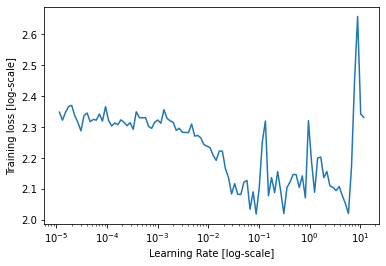

In [42]:
import matplotlib.pyplot as plot
plot.semilogx(np.array(alphas), np.array(loss_total))
plot.ylabel('Training loss [log-scale]')
plot.xlabel('Learning Rate [log-scale]')

In [47]:
min_idx = np.argmin(np.array(loss_total))
eta_star = alphas[min_idx]
eta_max = eta_star/10
print("$\eta_{star}: "+str(eta_star))
print("$\eta_{max}: "+str(eta_max))

$\eta_{star}: 0.08817787387069001
$\eta_{max}: 0.008817787387069


The learning rate corresponding to the minimum loss is $\eta_{star}$. However, the optimal learning rate is $\eta_{max} = \eta_{star}/10 = 0.0088$ which is in agreement with expectations.

(c) 

Using the optimal learning rate in (b), we now train the neural network using a cosine annealing. We have found that $\eta_{max}$ should be 0.0088, so we will use this choice moving forward. We can now use this to train our model over 50 epochs, as shown below. 

In [7]:
tr_loss = [] 
tr_error = [] 
te_loss = [] 
te_error = [] 
alphas = [] 
t = 0
T_max = 391*50 
T_0 = T_max/5 
eta_max = 0.0088 
net = allcnn_t()
net.to(torch.device("cuda:0"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=eta_max, momentum=0.9, weight_decay=0.001)
for epoch in range(50): 
  for i, data in enumerate(trainloader, 0): 
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      if t <= T_0:
        alpha = 10**(-4) + (t/T_0)*eta_max  
      else: 
        alpha = eta_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

      for g in optimizer.param_groups:
        g['lr'] = alpha 
      alphas.append(alpha)
      optimizer.step()
      t+=1
      loss_t = loss.item()
      for g in optimizer.param_groups:
        alpha_t = g['lr']
      correct = 0
      total = 0.  
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      acc_tr_t =  100 * correct / total     
      tr_loss.append(loss_t) 
      tr_error.append(100-acc_tr_t)
      print('Train loss:'+ " " +str(t)+" "+str(loss_t))
      print('Train accuracy:'+ " " +str(t)+" "+str(acc_tr_t))

  for i, data in enumerate(testloader, 0):
    correct = 0
    total = 0. 
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    acc_te_t =  100 * correct / total   
    te_error.append(100-acc_te_t)
    loss = criterion(outputs, labels)
    loss_t = loss.item()
    te_loss.append(loss_t)

Streaming output truncated to the last 5000 lines.
Train loss: 17051 0.0884956568479538
Train accuracy: 17051 98.4375
Train loss: 17052 0.09202343225479126
Train accuracy: 17052 96.875
Train loss: 17053 0.11902455985546112
Train accuracy: 17053 96.875
Train loss: 17054 0.09223014861345291
Train accuracy: 17054 97.65625
Train loss: 17055 0.12474110722541809
Train accuracy: 17055 95.3125
Train loss: 17056 0.06672678887844086
Train accuracy: 17056 98.4375
Train loss: 17057 0.1103963702917099
Train accuracy: 17057 96.09375
Train loss: 17058 0.08081574738025665
Train accuracy: 17058 99.21875
Train loss: 17059 0.07421796768903732
Train accuracy: 17059 100.0
Train loss: 17060 0.07834193110466003
Train accuracy: 17060 97.65625
Train loss: 17061 0.11744491010904312
Train accuracy: 17061 97.65625
Train loss: 17062 0.17351876199245453
Train accuracy: 17062 96.09375
Train loss: 17063 0.08791220933198929
Train accuracy: 17063 98.4375
Train loss: 17064 0.09256426990032196
Train accuracy: 17064 96.87

In [8]:
checkpoint = {'net': net.state_dict()}
torch.save(checkpoint, '/content/allcnn_net_checkpoint_v0.pt')

In [9]:
checkpoint = torch.load('/content/allcnn_net_checkpoint_v0.pt')
# net.load_state_dict(checkpoint['net']) #Prints IncompatibleKeys(missing_keys=[], unexpected_keys=[]) upon a successful load_state_dict ¯\_(ツ)_/¯

Text(0.5, 0, 'Time step')

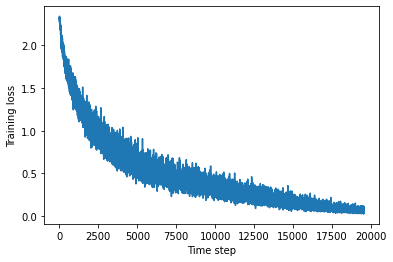

In [11]:
import matplotlib.pyplot as plot
t_step = np.array(range(len(tr_loss)))
plot.plot(t_step, np.array(tr_loss))
plot.ylabel('Training loss')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

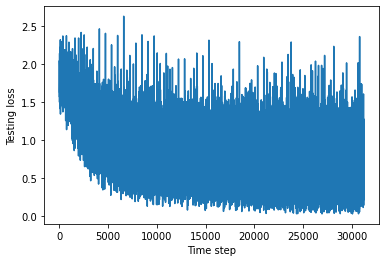

In [14]:
t_step = np.array(range(len(te_loss)))
plot.plot(t_step, np.array(te_loss))
plot.ylabel('Testing loss')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

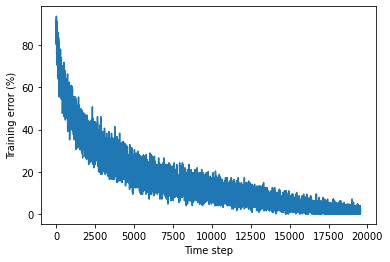

In [15]:
t_step = np.array(range(len(tr_error)))
plot.plot(t_step, np.array(tr_error))
plot.ylabel('Training error (%)')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

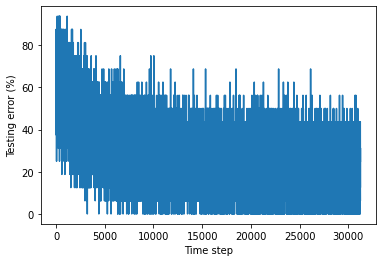

In [16]:
t_step = np.array(range(len(te_error)))
plot.plot(t_step, np.array(te_error))
plot.ylabel('Testing error (%)')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

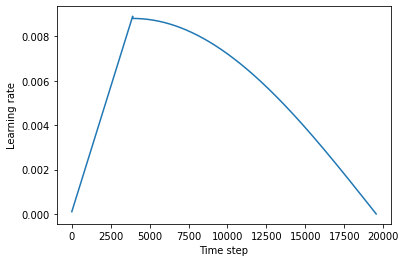

In [17]:
t_step = np.array(range(len(alphas)))
plot.plot(t_step, np.array(alphas))
plot.ylabel('Learning rate')
plot.xlabel('Time step')

(c) 

(ii) Here, we use $5\eta_{max}$ and $\rho = 0.5$. 

In [18]:
tr_loss = [] 
tr_error = [] 
te_loss = [] 
te_error = [] 
alphas = [] 
t = 0
T_max = 391*50 
T_0 = T_max/5 
eta_max = 5*0.0088 
net = allcnn_t()
net.to(torch.device("cuda:0"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=eta_max, momentum=0.5, weight_decay=0.001)
for epoch in range(50): 
  for i, data in enumerate(trainloader, 0): 
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      if t <= T_0:
        alpha = 10**(-4) + (t/T_0)*eta_max  
      else: 
        alpha = eta_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

      for g in optimizer.param_groups:
        g['lr'] = alpha 
      alphas.append(alpha)
      optimizer.step()
      t+=1
      loss_t = loss.item()
      for g in optimizer.param_groups:
        alpha_t = g['lr']
      correct = 0
      total = 0.  
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      acc_tr_t =  100 * correct / total     
      tr_loss.append(loss_t) 
      tr_error.append(100-acc_tr_t)
      print('Train loss:'+ " " +str(t)+" "+str(loss_t))
      print('Train accuracy:'+ " " +str(t)+" "+str(acc_tr_t))

  for i, data in enumerate(testloader, 0):
    correct = 0
    total = 0. 
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    acc_te_t =  100 * correct / total   
    te_error.append(100-acc_te_t)
    loss = criterion(outputs, labels)
    loss_t = loss.item()
    te_loss.append(loss_t)

Streaming output truncated to the last 5000 lines.
Train loss: 17051 0.09512358903884888
Train accuracy: 17051 99.21875
Train loss: 17052 0.07287422567605972
Train accuracy: 17052 99.21875
Train loss: 17053 0.08944082260131836
Train accuracy: 17053 97.65625
Train loss: 17054 0.09234104305505753
Train accuracy: 17054 98.4375
Train loss: 17055 0.09355957061052322
Train accuracy: 17055 98.4375
Train loss: 17056 0.06687185168266296
Train accuracy: 17056 100.0
Train loss: 17057 0.12104995548725128
Train accuracy: 17057 96.875
Train loss: 17058 0.09725598990917206
Train accuracy: 17058 96.09375
Train loss: 17059 0.09384226053953171
Train accuracy: 17059 97.65625
Train loss: 17060 0.07969562709331512
Train accuracy: 17060 98.4375
Train loss: 17061 0.10393659770488739
Train accuracy: 17061 96.875
Train loss: 17062 0.09451837837696075
Train accuracy: 17062 97.65625
Train loss: 17063 0.09724493324756622
Train accuracy: 17063 98.4375
Train loss: 17064 0.13528814911842346
Train accuracy: 17064 97.

Text(0.5, 0, 'Time step')

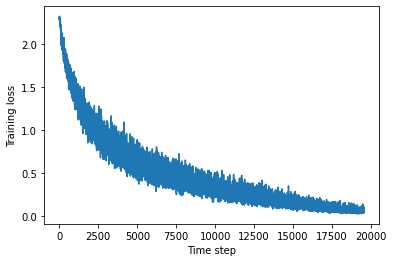

In [19]:
t_step = np.array(range(len(tr_loss)))
plot.plot(t_step, np.array(tr_loss))
plot.ylabel('Training loss')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

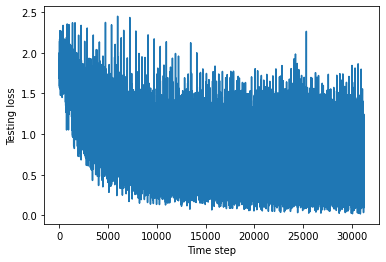

In [20]:
t_step = np.array(range(len(te_loss)))
plot.plot(t_step, np.array(te_loss))
plot.ylabel('Testing loss')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

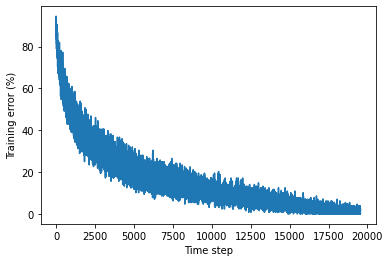

In [21]:
t_step = np.array(range(len(tr_error)))
plot.plot(t_step, np.array(tr_error))
plot.ylabel('Training error (%)')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

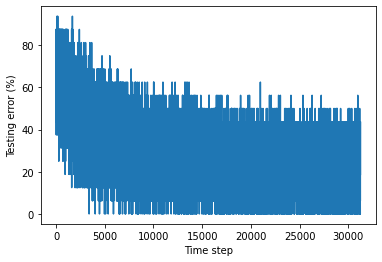

In [22]:
t_step = np.array(range(len(te_error)))
plot.plot(t_step, np.array(te_error))
plot.ylabel('Testing error (%)')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

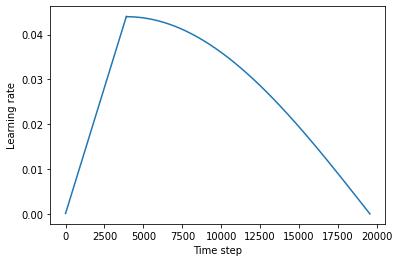

In [23]:
t_step = np.array(range(len(alphas)))
plot.plot(t_step, np.array(alphas))
plot.ylabel('Learning rate')
plot.xlabel('Time step')

(iii) $\eta_{max}$ and $\rho = 0.5$. 

In [24]:
tr_loss = [] 
tr_error = [] 
te_loss = [] 
te_error = [] 
alphas = [] 
t = 0
T_max = 391*50 
T_0 = T_max/5 
eta_max = 0.0088 
net = allcnn_t()
net.to(torch.device("cuda:0"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=eta_max, momentum=0.5, weight_decay=0.001)
for epoch in range(50): 
  for i, data in enumerate(trainloader, 0): 
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      if t <= T_0:
        alpha = 10**(-4) + (t/T_0)*eta_max  
      else: 
        alpha = eta_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

      for g in optimizer.param_groups:
        g['lr'] = alpha 
      alphas.append(alpha)
      optimizer.step()
      t+=1
      loss_t = loss.item()
      for g in optimizer.param_groups:
        alpha_t = g['lr']
      correct = 0
      total = 0.  
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      acc_tr_t =  100 * correct / total     
      tr_loss.append(loss_t) 
      tr_error.append(100-acc_tr_t)
      print('Train loss:'+ " " +str(t)+" "+str(loss_t))
      print('Train accuracy:'+ " " +str(t)+" "+str(acc_tr_t))

  for i, data in enumerate(testloader, 0):
    correct = 0
    total = 0. 
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    acc_te_t =  100 * correct / total   
    te_error.append(100-acc_te_t)
    loss = criterion(outputs, labels)
    loss_t = loss.item()
    te_loss.append(loss_t)

Streaming output truncated to the last 5000 lines.
Train loss: 17051 0.3689011037349701
Train accuracy: 17051 86.71875
Train loss: 17052 0.3456517159938812
Train accuracy: 17052 89.0625
Train loss: 17053 0.40717342495918274
Train accuracy: 17053 89.84375
Train loss: 17054 0.30353844165802
Train accuracy: 17054 89.84375
Train loss: 17055 0.35950514674186707
Train accuracy: 17055 90.625
Train loss: 17056 0.3596426844596863
Train accuracy: 17056 86.71875
Train loss: 17057 0.26484453678131104
Train accuracy: 17057 92.1875
Train loss: 17058 0.31760168075561523
Train accuracy: 17058 89.84375
Train loss: 17059 0.27741456031799316
Train accuracy: 17059 90.625
Train loss: 17060 0.344660222530365
Train accuracy: 17060 89.84375
Train loss: 17061 0.32493269443511963
Train accuracy: 17061 89.84375
Train loss: 17062 0.3689810335636139
Train accuracy: 17062 89.0625
Train loss: 17063 0.37537288665771484
Train accuracy: 17063 85.9375
Train loss: 17064 0.40940314531326294
Train accuracy: 17064 85.9375
T

Text(0.5, 0, 'Time step')

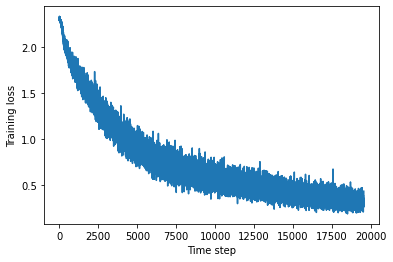

In [25]:
t_step = np.array(range(len(tr_loss)))
plot.plot(t_step, np.array(tr_loss))
plot.ylabel('Training loss')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

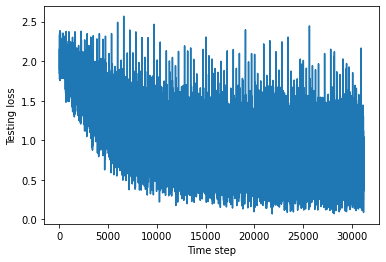

In [26]:
t_step = np.array(range(len(te_loss)))
plot.plot(t_step, np.array(te_loss))
plot.ylabel('Testing loss')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

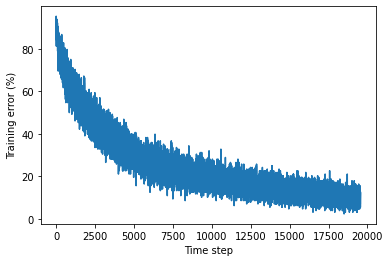

In [27]:
t_step = np.array(range(len(tr_error)))
plot.plot(t_step, np.array(tr_error))
plot.ylabel('Training error (%)')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

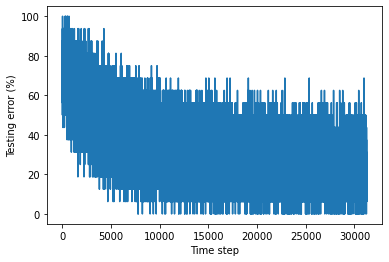

In [28]:
t_step = np.array(range(len(te_error)))
plot.plot(t_step, np.array(te_error))
plot.ylabel('Testing error (%)')
plot.xlabel('Time step')

Text(0.5, 0, 'Time step')

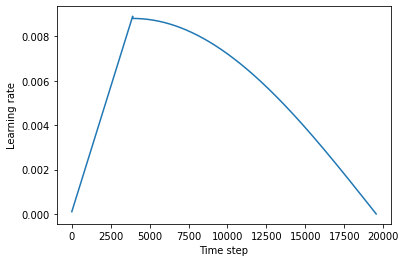

In [29]:
t_step = np.array(range(len(alphas)))
plot.plot(t_step, np.array(alphas))
plot.ylabel('Learning rate')
plot.xlabel('Time step')